## Description


Le but du challenge est de réussir à prédire dans quelle phase de sommeil se trouve un patient à partir de 11 signaux de 30s: 7 électroencéphalogrammes échantillonnés à 50 Hz, 3 accéléromètres  échantillonnés à 10Hz, 1 signal de pulsoxymètre aussi échantillonné à 10Hz.

### Prétraitement des données

On récupére les données des 7 eeg

In [0]:
import numpy
import scipy
from scipy.signal import butter,freqs, lfilter
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import pywt
import numpy as np

x_train = h5py.File('X_train.h5', 'r')
y_train = pd.read_csv('y_train.csv')
x_test = h5py.File('X_test.h5', 'r')
x_test_or_train = x_train

x1 = pd.DataFrame(x_test_or_train['eeg_1'][:])
x2 = pd.DataFrame(x_test_or_train['eeg_2'][:])
x3 = pd.DataFrame(x_test_or_train['eeg_3'][:])
x4 = pd.DataFrame(x_test_or_train['eeg_4'][:])
x5 = pd.DataFrame(x_test_or_train['eeg_5'][:])
x6 = pd.DataFrame(x_test_or_train['eeg_6'][:])
x7 = pd.DataFrame(x_test_or_train['eeg_7'][:])

xs =[x1, x2, x3, x4, x5, x6, x7]

On représente un exemple de ces 7 signaux

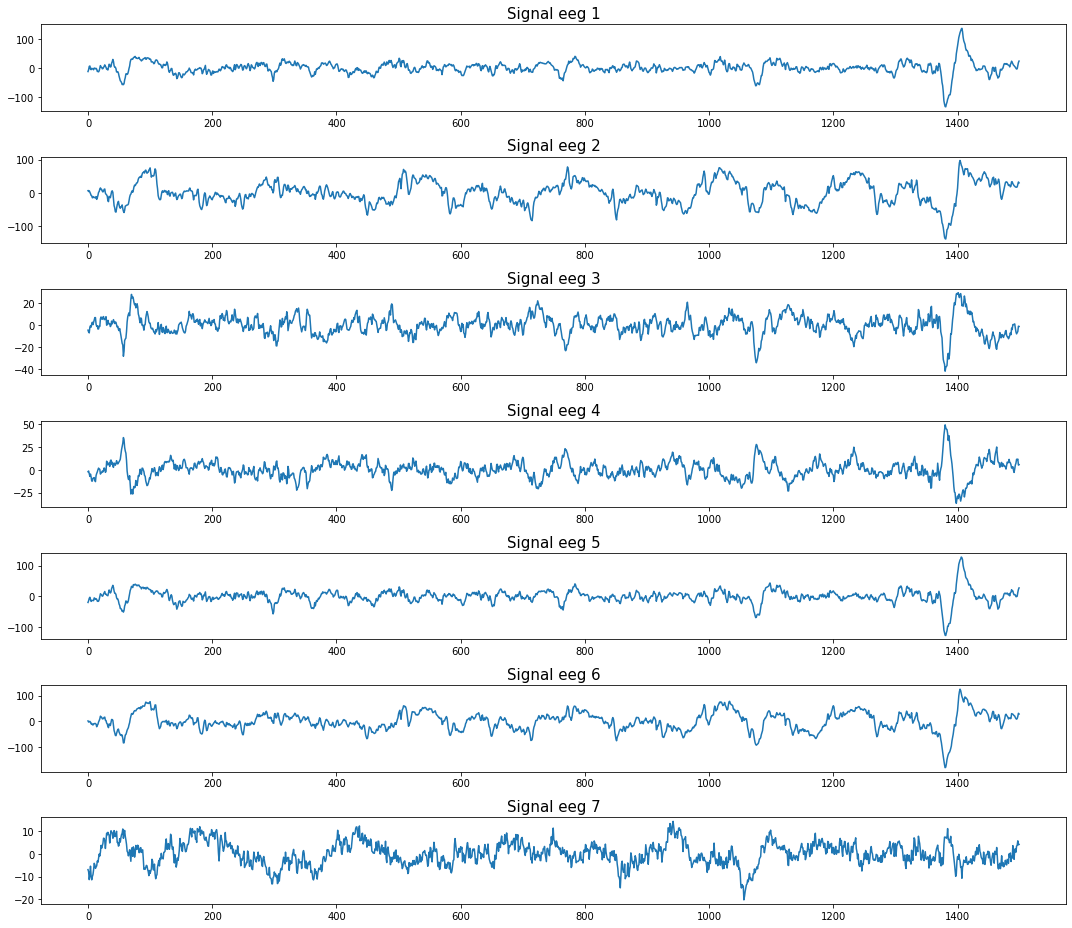

In [0]:
ex1 = x1.iloc[1000]
ex2 = x2.iloc[1000]
ex3 = x3.iloc[1000]
ex4 = x4.iloc[1000]
ex5 = x5.iloc[1000]
ex6 = x6.iloc[1000]
ex7 = x7.iloc[1000]


fig, ax = plt.subplots(7,1,figsize=(15,13))
ax[0].plot(ex1)
ax[0].set_title('Signal eeg 1', fontsize=15)
ax[1].plot(ex2)
ax[1].set_title('Signal eeg 2', fontsize=15)
ax[2].plot(ex3)
ax[2].set_title('Signal eeg 3', fontsize=15)
ax[3].plot(ex4)
ax[3].set_title('Signal eeg 4', fontsize=15)
ax[4].plot(ex5)
ax[4].set_title('Signal eeg 5', fontsize=15)
ax[5].plot(ex6)
ax[5].set_title('Signal eeg 6', fontsize=15)
ax[6].plot(ex7)
ax[6].set_title('Signal eeg 7', fontsize=15)
fig.tight_layout()

En représentant la distribution des 5 classes, on observe des inégalités entre celles-ci

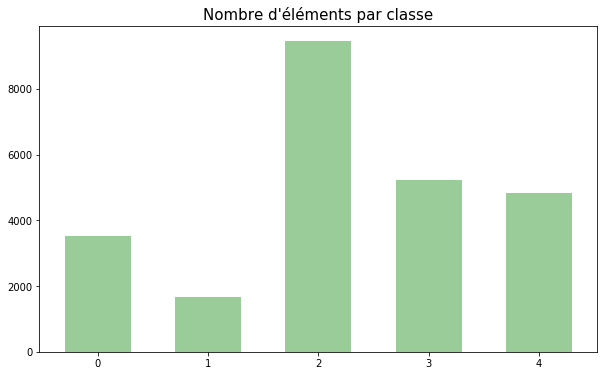

In [0]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 6), sharex=True)
ax.set_title("Nombre d'éléments par classe", fontsize=15)
sns.distplot(y_train['sleep_stage'].values, kde=False, color='g',  bins=[-.3,0.3, 0.7,1.3, 1.7, 2.3, 2.7, 3.3, 3.7, 4.3 ])

La prochaine étape est la décomposition spectrale du signal en utilisant des filtres de butterworth (voir article donné) par rapport aux bandes de fréquences $\delta$ (0-4 Hz), $\theta$ (4-8 Hz), $\alpha$ (8-13 Hz) et $\beta$ (>13 Hz). Nous avons choisi de faire cette décomposition car elle très utilisée dans les techniques usuelles de classification de signaux EEG.

On construit les filtres de butterworth en représentant la fonction de gain adéquate en choisissant les bonnes fréquences de cutoff (borne supérieure et borne inférieure).

In [0]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='high')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass_filter(data,  highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [0]:
def run():

    fs = 50
    highcut = 6.5

    plt.figure(1)
    plt.clf()
    for order in [20,25, 30]:
        b, a = butter_lowpass(highcut, fs, order=order)
        w, h = freqz(b, a)
        plt.plot((fs * 0.3 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.3 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Butterworth fiter : Delta waves')

"\n    # Filter a noisy signal.\n    T = 0.05\n    nsamples = T * fs\n    t = np.linspace(0, T, nsamples, endpoint=False)\n    a = 0.02\n    f0 = 600.0\n    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))\n    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)\n    x += a * np.cos(2 * np.pi * f0 * t + .11)\n    x += 0.03 * np.cos(2 * np.pi * 2000 * t)\n    plt.figure(2)\n    plt.clf()\n    plt.plot(t, x, label='Noisy signal')\n\n    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)\n    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)\n    plt.xlabel('time (seconds)')\n    plt.hlines([-a, a], 0, T, linestyles='--')\n    plt.grid(True)\n    plt.axis('tight')\n    plt.legend(loc='upper left')\n\n    plt.show()\n"

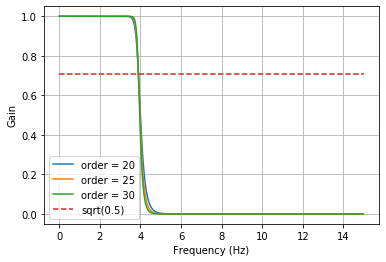

In [0]:
run()

In [0]:
def run2():
    fs = 50
    lowcut = 6.5
    highcut = 13.5
    plt.figure(1)
    plt.clf()
    for order in [21, 22]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a)
        plt.plot((fs * 0.3 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.3 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Butterworth fiter : Theta waves')

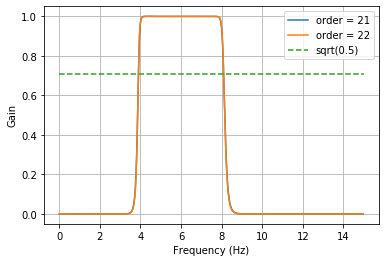

In [0]:
run2()

In [0]:
def run3():
    fs = 50
    lowcut = 13.5
    highcut = 21.7

    plt.figure(1)
    plt.clf()
    for order in [15,16,17]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a)
        plt.plot((fs * 0.3 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.3 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Butterworth fiter : Alpha waves')

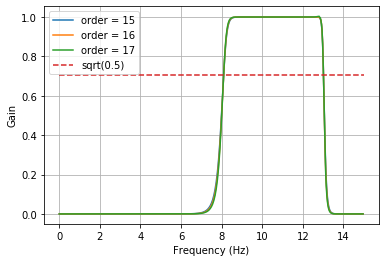

In [0]:
run3()

In [0]:
def run4():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 50
    lowcut = 22
    #highcut = 22

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [13,14,15]:
        b, a = butter_highpass(lowcut, fs, order=order)
        w, h = freqz(b, a)#, worN=2000)
        plt.plot((fs * 0.3 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.3 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Butterworth fiter : Beta waves')

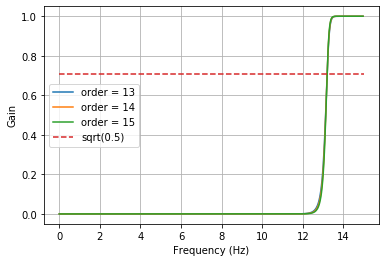

In [0]:
run4()

In [0]:
butter_info = {'delta':{'N': 30, 'highcut':6.5},
               'theta': {'N': 22, 'lowcut': 6.5, 'highcut':13.5},
               'alpha': {'N': 16, 'lowcut': 13.5, 'highcut': 21.7}
               }

butter_delta = lambda x: butter_lowpass_filter(x, butter_info['delta']['highcut'],fs=50, order=butter_info['delta']['N'])
butter_theta = lambda x: butter_bandpass_filter(x, butter_info['theta']['lowcut'], butter_info['theta']['highcut'], fs=50, order=butter_info['theta']['N'])
butter_alpha = lambda x: butter_bandpass_filter(x, butter_info['alpha']['lowcut'], butter_info['alpha']['highcut'],fs=50, order=butter_info['alpha']['N'])
butter_beta = lambda x: butter_highpass_filter(x, butter_info['beta']['lowcut'], fs=50, order=butter_info['beta']['N'])

On représente un signal et ses 3 composantes résultantes des filtrations dans les bandes $\delta$, $\theta$, $\alpha$ et $\beta$

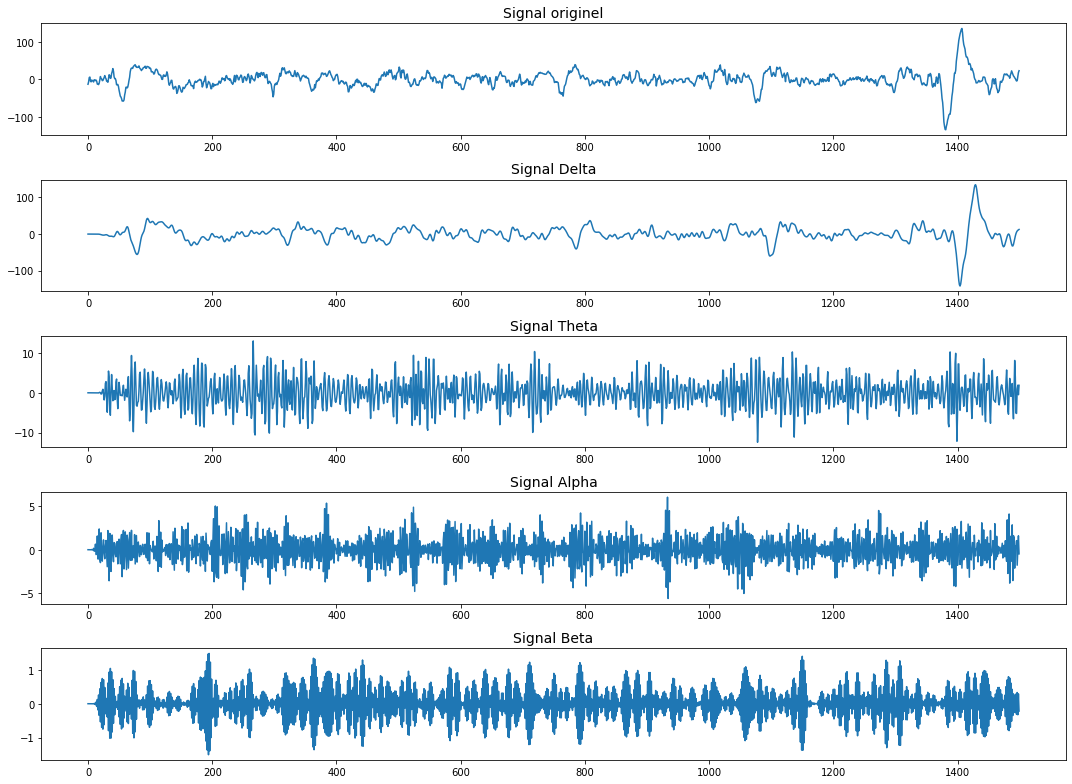

In [0]:
fig, ax = plt.subplots(5,figsize=(15,11))
ax[0].plot(x1.iloc[1000])
ax[0].set_title('Signal originel', fontsize=14)
ax[1].plot(butter_delta(x1.iloc[1000]))
ax[1].set_title('Signal Delta', fontsize=14)
ax[2].plot(butter_theta(x1.iloc[1000]))
ax[2].set_title('Signal Theta', fontsize=14)
ax[3].plot(butter_alpha(x1.iloc[1000]))
ax[3].set_title('Signal Alpha', fontsize=14)
ax[4].plot(butter_beta(x1.iloc[1000]))
ax[4].set_title('Signal Beta', fontsize=14)
fig.tight_layout()

On observe que les filtres de butterworth ont bien fonctionné. Le signal delta est le signal débruité alors que les signaux theta, alpha et beta sont le bruit à différentes fréquences.

On a finalement 28 signaux : delta, theta, alpha et beta pour chacun des 7 eeg.

En second lieu, on divise chaque signal de 30 secondes (1500 colonnes) en 3 epochs de signaux de 10 secondes (500 colonnes). 

Nos signaux sont alors dupliqués : on obtient environ 72k lignes au lieu de 24k (pour chacun des 28 types de signaux)

![Texte alternatif…](https://drive.google.com/uc?id=1o0wb1DcwtuS7eV57_vu4Xjrx22dNi6O4)

## Extraction des features

Dans cette partie, nous voulons extraire un maximum de features pertinents pour la classification de nos signaux. Au lieu d'utiliser simplement des charactéristiques classiques de signaux, nous avons utilisé les travaux de spécialistes de neurosciences qui nous fournissent à la fois une liste de features pertinents et des librairies Python facilitant leur extraction:


- EntroPy : https://github.com/raphaelvallat/entropy
- Pyeeg (python 2) : https://www.hindawi.com/journals/cin/2011/406391/
- Hurst : https://pypi.org/project/hurst/

Features statistiques :

*   Minimum
*   Maximum
*   Variance
*   Moyenne
*   Moment d'ordre 3
*   Moment d'ordre 4

Entropies:

* Permutation entropy
* Approximate entropy
* Singular value decomposition entropy
* Spectral entropy
* Sample entropy

Autres :

* Petrosian fractal dimension
* Katz fractal dimension
* Higuchi fractal dimension
* Detrended fluctuation analysis
* Hjorth mobility
* Hjorth complexity
* Hurst exponent
* Maximum-Minimum Distance (MMD) : voir article "Sleep Stage Classification Using EEG Signal Analysis"
* les puissances des 3 premières harmoniques du signal

Ce qui fait 22 features pour 28 signaux, donc au total : 616 features (colonnes).
Puisque dans la suite on va utiliser un modèle d'arbres, il n'y pas besoin de normaliser les données.

On présente le code pour l'extraction de la MMD (maximum mean discrepancy). Pour les autres features nous avons uniquement utilisé les librairies.


In [0]:
# fonction d'extraction de la feature MMD

def mmd_epoch(data):
  y_max = np.max(data)
  y_min = np.min(data)
  x_max = np.argmin(data)
  x_min = np.argmin(data)
  return np.sqrt((y_max-y_min)**2 + (x_max-x_min)**2)

def mmd(data, lmbda=100):
  n = data.shape[0]//lmbda
  return np.sum([mmd_epoch(data[i*lmbda:(i+1)*lmbda]) for i in range(n)])

## Construction du modèle

Nous avons utilisé comme modèle le LGBM (Light Gradient Boosting Machine). Les modèles les plus performants pour ces données (616 features pour 74k lignes) sont les Gradient Boosting Machines (GBM). Nous avons choisis le LGBM car il s'agit d'une version accélérée des GBM, donc il va nous permettre de l'entraîner plusieurs fois afin de trouver les meilleurs hyperparamètres qui permettent d'obtenir le meilleur résultat dans la partie de cross-validation.

Sous Python il s'implémente facilement avec la librairie LightGBM, comme ci-dessous.

In [0]:
from lightgbm import LGBMClassifier 

lgbm = LGBMClassifier(boosting_type="gbdt",
                      num_leaves = 70, 
                      max_depth = 10,
                      colsample_bytree=.5,
                      n_estimators = 500,
                      min_child_samples=10,
                      subsample=.632,
                      subsample_freq=1,
                      reg_alpha=10, 
                      reg_lambda=7,
                      n_jobs=-1,
                      tree_learner='voting',
                      max_bin = 100,
                      min_gain_to_split = .5
                      )

#### Description du modèle LGBM




**1) Idée générale** <br>
Light GBM est un algorithme de boosting: on combine plusieurs classeurs faibles entrainés sequentiellement afin d'obtenir un classeur fort. Plus particulièrement c'est un "Gradient Boosting Decision Tree" (GBDT): les classeurs faibles choisis sont des arbres de décision.

La différence entre LGBM et les autres GBDT vus en cours réside dans la manière dont les arbes sont entrainés. Dans les modèles classiques le coût d'entrainement est très élevé car à chaque étape tous les paramètres et toutes les instances sont examinés pour déterminer le point de séparation optimal. L'idée de LGBM est de rendre l'algorithme plus efficace en n'examinant qu'un nombre réduits de paramètres et d'instances.

**2) Réduction du nombre d'instances à examiner** <br>
La méthode utilisée pour cela est appelée "Gradient-based One-Side Sampling" (GOSS). On veut réduire le nombre d'instances à examiner mais avec une meilleure performance qu'un simple échantillonnage aléatoire. Pour cela on utilise les valeurs du gradient de la fonction d'erreur pour les différentes instances. Les instances associées à un grand gradient ont été sous-entrainées: l'algorithme les conserve toutes car elles donnent plus d'information. Au contraire, les instances associées à un gradient faible apportent peu d'information, l'algorithme n'en conserve qu'un échantillon aléatoire.

**3) Réduction du nombre de paramètres à examiner** <br>
La méthode utilisée pour cela est appelée "Exclusive Feature Bundling" (EFB). L'idée pour réduire de le nombre paramètres à examiner est de profiter du fait que certains d'entre-eux sont exclusifs : ils ne peuvent pas prendre des valeurs non nulles en même temps (par exemple lorsqu'on a fait du one-hot encoding). Les paramètres exclusifs sont donc regroupés ensemble. Pour augmenter l'efficacité l'algorithme peut aussi regrouper les paramètres qui ne sont pas totalement mutuellement exclusifs (en tolérant en petite fraction de conflits), ce qui affecte légèrement la précision de la prédiction.

Une difficulté de cette méthode est que la détermination du regroupement des paramètres exclusifs optimal (c'est-à-dire avec le plus faible nombre de paquets) est un problème NP-difficile. La solution choisie a été de le réduire au problème du coloriage de graphe (les noeuds sont les paramètres, ils sont reliés par une arrête s'ils ne sont pas mutuellement exclusifs), puis de le résoudre avec l'algorithme glouton suivant:


1.   On construit le graphe avec des arrêtes pondérées par le nombre de conflits entre les 2 paramètres 
2.   On trie les paramètres dans l'ordre décroissant de leur degré dans le graphe
3.   On examine chaque paramètre de la liste et on l'assigne à un paquet avec un faible conflit ou on crée un nouveau paquet




**3) Source**<br>
Le modèle est décrit de manière détaillée dans l'article suivant:
https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf



#### Paramètres du modèle


Le modèle LGBM présente un grand nombre de paramètres:

*   num_leaves: nombre maximal de feuilles dans un arbre, on le diminue si on veut réduire le risque d'overfitting
*   max_depth : profondeur maximale de l'arbre. On diminue sa valeur lorsqu'on veut réduire le risque d'overfitting.
*   min_data_in_leaf : nombre maximum d'instances dans une feuille. Par défaut égal à 20, on peut l'augmenter pour réduire le risque d'overfitting.
*   learning_rate: détermine l'impact de chaque nouvel arbre sur le modèle global
*   n_estimators: nombre d'arbres utilisés dans le modèle
*   reg_alpha: paramètre de régularisation L1
*   reg_lambda: paramètre de régularisation L2
*   min_child_samples: nombre minimal d'instances dans une feuille
*   subsample: part des données qui sont sélectionnées à chaque étape pour créer un nouvel arbre. Permet d'accélerer l'entrainement
*   subsample_freq : fréquence à laquelle on pratique l'échantillonage, on choisit 1 pour échantilloner à chaque itération
*   min_gain_to_split: gain minimal pour séparer un noeud
*   early_stopping_round: permet d'arrêter l'entraînement si la performance du modèle ne s'améliore plus pendant plusieurs itérations
*   max_bin: nombre maximal de paquets dans lesquels on regroupe les features. Une valeur élevée augmente la précision, mais peut causer du sur-apprentissage.

#### Choix des paramètres

Le nombre de paramètres étant très important dans le modèle LGBM. Nous avons donc décidé de nous concentrer sur les valeurs des paramètres qui influencent le plus la précision et la capacité de généralisation du modèle : le nombre maximal de feuilles dans un arbre (num_leaves), la profondeur maximale des arbres (max_depth), le coefficient de régularisation L2 (reg_lambda).

Pour cela on utilise la méthode "GridSearchCV" sous Python qui nous permet de séléctionner les meilleures valeurs dans une liste donnée. La méthode de cross-validation mise en oeuvre est celle du k-fold cross validation avec 2 folds.

Pour les autres paramètres nous avons appliqué la méthode de GridSearch séparément sur chaque paramètre.

Nous avons choisi le paramètre tree_learner = "voting" comme moyen de parallèliser l'entraînement car il est adapté à un grand nombre de données et de features. 


In [0]:
from lightgbm import LGBMClassifier 
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier(boosting_type="gbdt",
                     # num_leaves = 70,
                     # max_depth = 10,
                      colsample_bytree=.5,
                      n_estimators = 800,
                      min_child_samples=10,
                      subsample=.632,
                      subsample_freq=1,
                      reg_alpha=0, 
                      #reg_lambda=7,
                      n_jobs=-1,
                      tree_learner='voting',
                      max_bin = 100,
                      min_gain_to_split = .5)

grid = {'num_leaves':[75, 80, 85],
        'reg_lambda':[9, 10, 11],
        'max_depth':[9,10,11]}

gridsearch = GridSearchCV(lgbm, param_grid = grid, scoring='f1_macro', n_jobs=-1, cv=2, verbose=5)

gridsearch.fit(x_train_1, y_train)

#### Entraînement

Après traitement et extraction des features, nos données ont la forme suivante :

![Texte alternatif…](https://drive.google.com/uc?id=1S5JxJBKjuZHVzRIYE-QIS9-l3FEA36ae)

Epoch 1 correspond aux 10 premières secondes \\
Epoch 2 correspond aux 10 secondes suivantes \\
Epoch 3 correspond aux 10 dernières secondes

On entraîne plusieurs copies du modèle sur différentes parties des données d'entraînement :

* 1 modèle pour l'ensemble des 3 epochs (74k lignes) : $[y_{11}, y_{12}, y_{13}]$ en sortie. Soit 1 modèle et 3 prédictions
* 1 modèle pour chaque groupe de 2 epochs (48k lignes) : $[y_{211}, y_{212}], [y_{221}, y_{222}], [y_{231},y_{232}]$ en sortie. Soit 3 modèles pour 6 prédictions.
* 1 modèle pour chaque epoch : $y_{31}, y_{32}, y_{33}$ en sortie. Soit 3 modèles pour 3 prédictions.

Pour obtenir  $y_{test}$ final, on applique une fonction de vote majoritaire entre les 12 $y$ résultants des 7 modèles. 

In [0]:
from lightgbm import LGBMClassifier 

def one_model_to_rule_them_all():
  print(0)
  model= LGBMClassifier(boosting_type="gbdt",
                      num_leaves = 70, 
                      max_depth = 10,
                      colsample_bytree=.5,
                      n_estimators = 1000,
                      min_child_samples=10,
                      subsample=.632,
                      subsample_freq=1,
                      reg_alpha=0, 
                      reg_lambda=7,
                      n_jobs=-1,
                      tree_learner='voting',
                      max_bin = 100,
                      min_gain_to_split = .5
                      )
  return model


l = x_train_all.shape[0]//3

m = x_test_all.shape[0]//3

x_train_1 = x_train_all.iloc[:l]
x_train_2 = x_train_all.iloc[l:l*2]
x_train_3 = x_train_all.iloc[l*2:]

x_test_1 = x_test_all.iloc[:m]
x_test_2 = x_test_all.iloc[m:m*2]
x_test_3 = x_test_all.iloc[m*2:]

x_train_12 = x_train_1.append(x_train_2)
x_train_13 = x_train_1.append(x_train_3)
x_train_23 = x_train_2.append(x_train_3)

x_test_12 = x_test_1.append(x_test_2)
x_test_13 = x_test_1.append(x_test_3)
x_test_23 = x_test_2.append(x_test_3)

model = one_model_to_rule_them_all()
model.fit(x_train_1, y_train)
y_pred_1_1 = model.predict(x_test_1)

model = one_model_to_rule_them_all()
model.fit(x_train_2, y_train)
y_pred_1_2 = model.predict(x_test_1)

model = one_model_to_rule_them_all()
model.fit(x_train_3, y_train)
y_pred_1_3 = model.predict(x_test_1)

model = one_model_to_rule_them_all()
model.fit(x_train_12, y_train.append(y_train))
y_pred_2_1 = model.predict(x_test_12)

model = one_model_to_rule_them_all()
model.fit(x_train_13, y_train.append(y_train))
y_pred_2_2 = model.predict(x_test_13)

model = one_model_to_rule_them_all()
model.fit(x_train_23, y_train.append(y_train))
y_pred_2_3 = model.predict(x_test_23)


y_pred_2_1_1 = y_pred_2_1[:m]
y_pred_2_1_2 = y_pred_2_1[m:]
y_pred_2_2_1 = y_pred_2_2[:m]
y_pred_2_2_2 = y_pred_2_2[m:]
y_pred_2_3_1 = y_pred_2_3[:m]
y_pred_2_3_2 = y_pred_2_3[m:]

model = one_model_to_rule_them_all()
model.fit(x_train_all, y_train_ext)

y_pred_3 = model.predict(x_test_all)

y_pred_3_1 = y_pred_3[:m]
y_pred_3_2 = y_pred_3[m:2*m]
y_pred_3_3 = y_pred_3[2*m:]

#La fonction de vote majoritaire
def best_vote(votes):
  votes_table = {} 
  votes_table[1]=0
  for vote in votes:
      if vote in votes_table:   
          votes_table[vote] += 1 
      else:
          votes_table[vote] = 1 
  return int(max(votes_table, key=votes_table.get))

df_y_test = pd.DataFrame([y_pred_1_1,y_pred_1_2,y_pred_1_3, 
                          y_pred_2_1_2, y_pred_2_1_2, y_pred_2_2_1,y_pred_2_2_2,y_pred_2_3_1,y_pred_2_3_2,
                          y_pred_3_1, y_pred_3_2, y_pred_3_3]).T

df_y_test['Final'] = df_y_test.apply(lambda row: best_vote(row), axis=1)

## Résultats

Le modèle présenté au-dessus est celui qui a donné les meilleurs réultats. Finalement nous n'avons donc utilisé que les données des EEG et pas les autres signaux, car cela diminuait notre score final lorsque les ajoutions.

En plus des prédictions de notre modele qui sont evaluees sur le Kaggle on peut regarder quels sont les features auxquels il attribue le plus d'importance. Voici les 50 features les plus importants, dans l'ordre:

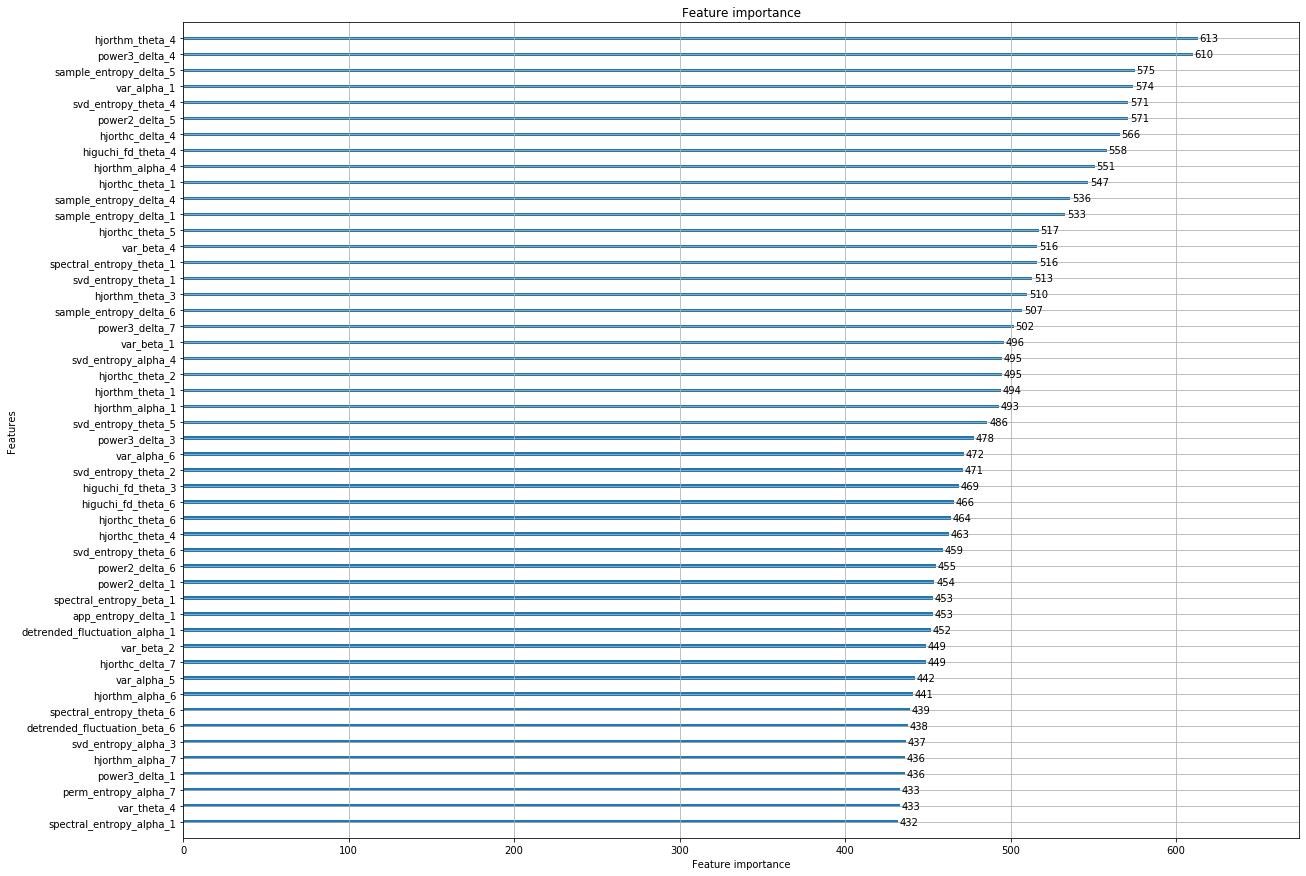

In [0]:
fig, ax = plt.subplots(figsize=(20,15))
lightgbm.plot_importance(model, ax=ax, max_num_features = 50)

On remarque l'importance de certaines features plus que d'autres, par exemple : la hjorth mobility du signal theta du 4ème eeg, la puissance de la 3ème harmonique du signal delta du 4ème eeg, etc ...

Considérons la matrice de corrélation de ces 50 features.

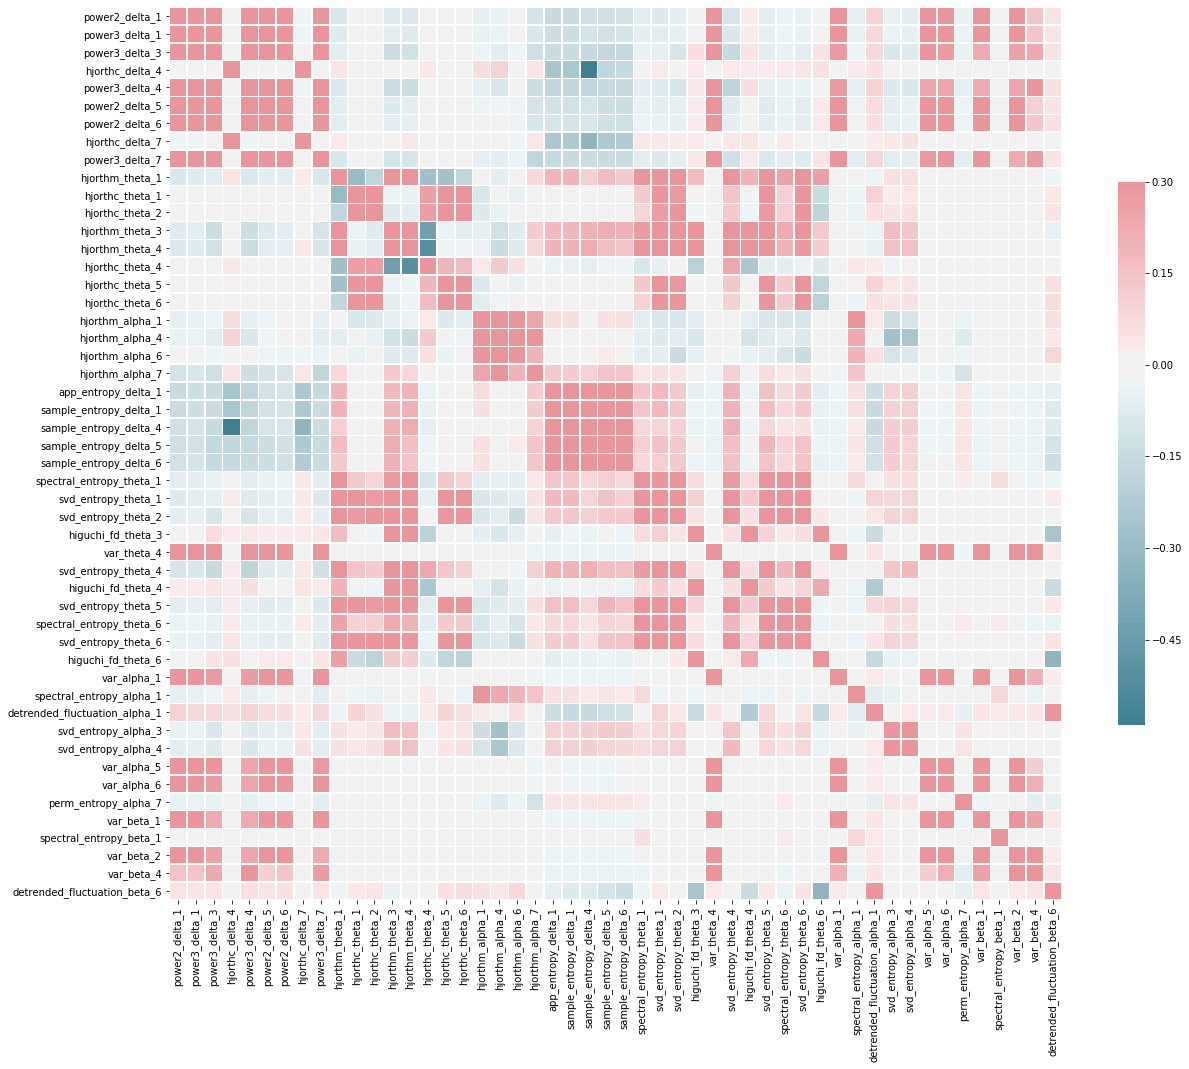

In [0]:
import seaborn as sns
corr = x_important.corr()
f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


On remarque que les variables de même nature pour les 7 signaux EEG sont corrélées entre eux (par exemple sample_entropy_delta). Si on voulait reduire le nombre de features et donc la complexite de l'entrainement on pourrait essayer d'utiliser uniquement les moyennes sur les 7 EEG.

Par ailleurs, des corrélations existent entre des variables différentes, par exemple, entre svd_entropy et hjorthm ou entre var_beta et power2_delta (ou power3_delta).